<a href="https://colab.research.google.com/github/c-cadona/gama/blob/main/Gama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Readme

**Reprodução do Artigo - Previsão de Irradiância**

Este notebook tem o objetivo de reproduzir os experimentos descritos no artigo que o Lorenzo me enviou utilizando o dataset Folsom. O foco será obter resultados comparáveis ao artigo, considerando diferentes condições climáticas:

- All: Todas as imagens do dataset
- Clear: Apenas imagens de céu limpo --> **Apenas esse por enquanto.**
- Cloudy: Apenas imagens nubladas

As métricas de avaliação utilizadas serão:
- RMSE (Erro Quadrático Médio)
- MAE (Erro Médio Absoluto)
- R² (Coeficiente de Determinação)
- Cross-Validation (KFold)

## 1. Preparando ambiente

- Instalação de bibliotecas
- Cuda

### 1.1 Bibliotecas

In [1]:
!pip install -U pandas matplotlib torch torchvision scikit-learn --quiet
!pip install --upgrade numpy scipy pandas matplotlib scikit-learn torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [2]:
# Importar PyTorch
import torch
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

# Importar bibliotecas adicionais
import os
import json
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

### 1.2 Cuda

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
  torch.manual_seed(42)

print(device)

cuda


## 2. Carregando os dados

- Acessar dados no drive
- Carregar os dados
- Organizar os dados

## 2.1 Acessando dados do drive

In [4]:
import os
from google.colab import drive

drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/Task - GAMMA"

# Verifica se já existe o link simbólico e remove antes de recriar
if os.path.exists("folsom_dataset") or os.path.islink("folsom_dataset"):
    os.unlink("folsom_dataset")  # Remove o link simbólico ou diretório existente

# Criar link simbólico para facilitar o acesso
os.symlink(os.path.join(base_path, "folsom_dataset"), "folsom_dataset")
print("Symbolic link created.")

print("Arquivos na pasta folsom_dataset:", os.listdir("folsom_dataset"))

Mounted at /content/drive
Symbolic link created.
Arquivos na pasta folsom_dataset: ['folsom_images.zip', 'test_timestamps.pkl', 'Folsom_irradiance.csv', 'df_date_modif.csv', 'hparams.json', 'leitura_arquivos.ipynb', 'README.txt', 'df_clear_sky.csv']


### 2.2 Extraindo dados

In [5]:
# unzippar as imagens dentro da VM do colab, para nao ocupar disco do drive
!unzip folsom_dataset/folsom_images.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: 2016/12/25/20161225_195000.npy  
  inflating: 2016/12/25/20161225_184700.npy  
  inflating: 2016/12/25/20161225_224600.npy  
  inflating: 2016/12/25/20161225_185159.npy  
  inflating: 2016/12/25/20161225_164559.npy  
  inflating: 2016/12/25/20161225_161359.npy  
  inflating: 2016/12/25/20161225_234900.npy  
  inflating: 2016/12/25/20161225_184900.npy  
  inflating: 2016/12/25/20161225_003809.npy  
  inflating: 2016/12/25/20161225_202300.npy  
  inflating: 2016/12/25/20161225_214259.npy  
  inflating: 2016/12/25/20161225_190759.npy  
  inflating: 2016/12/25/20161225_160259.npy  
  inflating: 2016/12/25/20161225_164900.npy  
  inflating: 2016/12/25/20161225_203959.npy  
  inflating: 2016/12/25/20161225_172259.npy  
  inflating: 2016/12/25/20161225_001509.npy  
  inflating: 2016/12/25/20161225_213500.npy  
  inflating: 2016/12/25/20161225_214459.npy  
  inflating: 2016/12/25/20161225_000008.npy  
  inflating: 2016/12/

### 2.3 Organizando dados

In [6]:
# date modified das imagens
df_date_modif = pd.read_csv("folsom_dataset/df_date_modif.csv", index_col=0, parse_dates=True)
df_date_modif

,date_modified,path
time_stamps,,
2014-01-02 15:28:08,2014-01-02 15:27:55,2014/01/02/20140102_152808.npy
2014-01-02 15:29:07,2014-01-02 15:28:53,2014/01/02/20140102_152907.npy
2014-01-02 15:30:08,2014-01-02 15:29:54,2014/01/02/20140102_153008.npy
2014-01-02 15:31:08,2014-01-02 15:30:54,2014/01/02/20140102_153108.npy
2014-01-02 15:32:08,2014-01-02 15:31:55,2014/01/02/20140102_153208.npy
...,...,...
2016-12-31 00:43:00,2016-12-31 00:31:39,2016/12/31/20161231_004300.npy
2016-12-31 00:44:00,2016-12-31 00:32:39,2016/12/31/20161231_004400.npy
2016-12-31 00:45:00,2016-12-31 00:33:39,2016/12/31/20161231_004500.npy


In [7]:
# dados de irradiance
df_irradiance = pd.read_csv("folsom_dataset/Folsom_irradiance.csv", index_col=0, parse_dates=True)
df_irradiance

,ghi,dni,dhi
timeStamp,,,
2014-01-02 08:00:00,0.0,0.0,0.0
2014-01-02 08:01:00,0.0,0.0,0.0
2014-01-02 08:02:00,0.0,0.0,0.0
2014-01-02 08:03:00,0.0,0.0,0.0
2014-01-02 08:04:00,0.0,0.0,0.0
...,...,...,...
2016-12-31 07:55:00,0.0,0.0,0.0
2016-12-31 07:56:00,0.0,0.0,0.0
2016-12-31 07:57:00,0.0,0.0,0.0


In [8]:
import pickle

# timestamps do conjunto de teste utilizado, LEVANDO EM CONSIDERAÇÃO O DATE MODIFIED COMO DATA REAL DAS IMAGENS
with open("folsom_dataset/test_timestamps.pkl", "rb") as f:
  test_timestamps = pd.to_datetime(pickle.load(f))
test_timestamps

DatetimeIndex(['2016-01-01 16:30:24', '2016-01-01 16:31:24',
               '2016-01-01 16:32:24', '2016-01-01 16:33:24',
               '2016-01-01 16:34:24', '2016-01-01 16:35:24',
               '2016-01-01 16:36:24', '2016-01-01 16:37:24',
               '2016-01-01 16:38:24', '2016-01-01 16:39:24',
               ...
               '2016-12-30 23:35:39', '2016-12-30 23:36:39',
               '2016-12-30 23:37:39', '2016-12-30 23:38:39',
               '2016-12-30 23:39:39', '2016-12-30 23:40:39',
               '2016-12-30 23:41:39', '2016-12-30 23:42:39',
               '2016-12-30 23:43:39', '2016-12-30 23:44:39'],
              dtype='datetime64[ns]', length=220755, freq=None)

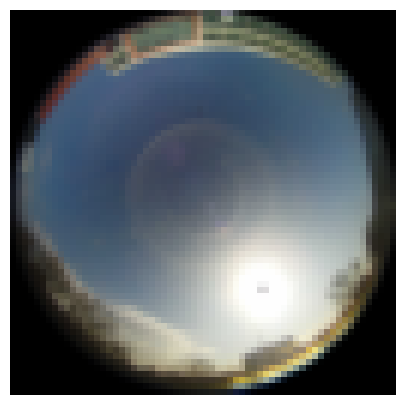

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(np.load(df_date_modif["path"].iloc[12345]))
ax.set_axis_off()

In [10]:
# hparams de treinamento
import json

with open("folsom_dataset/hparams.json", "r") as f:
  hparams = json.load(f)

batch_size = hparams["ResNet50"]["batch_size"]
learning_rate = hparams["ResNet50"]["learning_rate"]
dropout = hparams["ResNet50"]["dropout"]

## 3. Categorização - Sunmask

Utilizarei o pvlib - https://pvlib-python.readthedocs.io/en/stable/ para categorizar os dados e dividi-los como: Clear - Cloudy - All

**OBS**: Por enquanto utilizarei o csv que o Lorenzo me passou com os timestamps do céu limpo.

In [11]:
import pandas as pd

df_clear_sky = pd.read_csv("folsom_dataset/df_clear_sky.csv", index_col=0, parse_dates=True)

# Filtrando os dataframes para utilizar apenas céu limpo
df_date_modif_clear = df_date_modif[df_date_modif.index.isin(df_clear_sky.index)]
df_irradiance_clear = df_irradiance[df_irradiance.index.isin(df_clear_sky.index)]

In [12]:
# Instalando pvlib
# !pip uninstall -y numpy pvlib
# !pip install numpy
# !pip install --no-cache-dir pvlib

## 4. Dataset

### 4.1 Transform

In [13]:
from torchvision import transforms

transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor(),
])

### 4.2 Classe Dataset

In [14]:
from torch.utils.data import Dataset
from PIL import Image

class FolsomDataset(Dataset):
  def __init__(self, df_date_modif, df_irradiance, transform=None):
    """
      Args:
      df_date_modif (DataFrame): Contém os caminhos das imagens.
      df_irradiance (DataFrame): Contém os valores de irradiância indexados pelo timestamp.
      transform (callable, optional): Transformações a serem aplicadas às imagens.
      """
    self.df_date_modif = df_date_modif
    self.df_irradiance = df_irradiance
    self.transform = transform
    self.data = list(zip(df_date_modif["path"], df_irradiance["ghi"]))

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image_path, irradiance_value = self.data[idx]
    image_data = np.load(image_path)
    image = Image.fromarray(image_data.astype(np.uint8))

    if self.transform:
      image = self.transform(image)

    irradiance_value = torch.tensor(irradiance_value, dtype=torch.float32)
    return image, irradiance_value

### 4.3 DataLoader

In [15]:
from torch.utils.data import Subset, DataLoader

# Criando os datasets (treino e teste)
train_dataset = FolsomDataset(df_date_modif=df_date_modif_clear, df_irradiance=df_irradiance_clear, transform=transform)
test_dataset = FolsomDataset(df_date_modif=df_date_modif_clear, df_irradiance=df_irradiance_clear, transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
# num_workers=2)

# Criando sub sets
half_sets = len(train_dataset) // 2

train_subset = torch.utils.data.Subset(train_dataset, range(half_sets))
test_subset = torch.utils.data.Subset(test_dataset, range(half_sets))

# Criando os DataLoaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2)

## 5. Modelo

In [16]:
resnet50 = models.resnet50(weights="DEFAULT")

resnet50.fc = nn.Sequential(
  nn.Dropout(hparams["ResNet50"]["dropout"]),
  nn.Linear(resnet50.fc.in_features, 1)
)

loss_fn = nn.MSELoss()

optimizer = optim.AdamW(resnet50.parameters(), lr=hparams["ResNet50"]["learning_rate"], weight_decay=hparams["ResNet50"]["weight_decay"])

gamma=(1/10) ** (1/(0.75 * hparams["ResNet50"]["epochs"]))
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

model = resnet50.to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 130MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 6. Treinamento

### 6.1 Loop de treinamento

In [17]:
epochs = hparams["ResNet50"]["epochs"]

for epoch in range(epochs):
  model.train()
  running_loss = 0.0

  for images, targets in train_loader:
    images, targets = images.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = resnet50(images).squeeze()
    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  scheduler.step()

  print(f"Epoch {epoch+1}/{epochs}, Loss: {(running_loss/len(train_loader)):.4f}, LR: {optimizer.param_groups[0]['lr']:.15f}")


Epoch 1/16, Loss: 56214.6524, LR: 0.000660323348214
Epoch 2/16, Loss: 35082.2595, LR: 0.000545033655246
Epoch 3/16, Loss: 20920.7483, LR: 0.000449873060152
Epoch 4/16, Loss: 12744.7214, LR: 0.000371327106689
Epoch 5/16, Loss: 8994.5229, LR: 0.000306494947965
Epoch 6/16, Loss: 6216.4316, LR: 0.000252982212813
Epoch 7/16, Loss: 4505.2783, LR: 0.000208812577255
Epoch 8/16, Loss: 4478.0636, LR: 0.000172354775203
Epoch 9/16, Loss: 2801.3722, LR: 0.000142262352803
Epoch 10/16, Loss: 2106.3887, LR: 0.000117423941410
Epoch 11/16, Loss: 1863.8478, LR: 0.000096922212690
Epoch 12/16, Loss: 1351.3805, LR: 0.000080000000000
Epoch 13/16, Loss: 1142.2905, LR: 0.000066032334821
Epoch 14/16, Loss: 958.9538, LR: 0.000054503365525
Epoch 15/16, Loss: 767.4594, LR: 0.000044987306015
Epoch 16/16, Loss: 670.5071, LR: 0.000037132710669


### 6.2 Fazendo predições

In [18]:
import numpy as np
import torch

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

def predict(model, dataloader, device):
  model.eval()
  predictions, ground_truths = [], []

  with torch.inference_mode():
    for images, targets in dataloader:
      images, targets = images.to(device), targets.to(device)
      outputs = model(images).squeeze()

      predictions.extend(outputs.cpu().numpy())
      ground_truths.extend(targets.cpu().numpy())

  return np.array(predictions), np.array(ground_truths)

## 7. Avaliando modelo

In [19]:
!pip install --upgrade numpy scipy torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 25.1 MB/s eta 0:00:00


In [22]:
import torch

def evaluate_model(predictions, ground_truths):
    predictions = torch.tensor(predictions, dtype=torch.float32)
    ground_truths = torch.tensor(ground_truths, dtype=torch.float32)

    # Erro quadrático médio (MSE) e RMSE
    mse = torch.mean((predictions - ground_truths) ** 2)
    rmse = torch.sqrt(mse)

    # Erro absoluto médio (MAE)
    mae = torch.mean(torch.abs(predictions - ground_truths))

    # Desvio padrão dos erros (RMSE e MAE)
    std_rmse = torch.std((predictions - ground_truths) ** 2).sqrt()
    std_mae = torch.std(torch.abs(predictions - ground_truths))

    # R² Score (coeficiente de determinação)
    ss_res = torch.sum((ground_truths - predictions) ** 2)
    ss_tot = torch.sum((ground_truths - torch.mean(ground_truths)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else torch.tensor(0.0)

    return rmse.item(), std_rmse.item(), mae.item(), std_mae.item(), r2.item()


In [24]:
predictions, ground_truths = predict(model, test_loader, device)
rmse, std_rmse, mae, std_mae, r2 = evaluate_model(predictions, ground_truths)

print(f"RMSE: {rmse:.2f} ± {std_rmse:.2f} W/m²")
print(f"MAE: {mae:.2f} ± {std_mae:.2f} W/m²")
print(f"R²: {r2}")

RMSE: 23.77 ± 65.30 W/m²
MAE: 11.92 ± 20.56 W/m²
R²: 0.991427481174469


Gabarito:

- RMSE: 12.89 ± 0.39 W/m²
- MAE: 9.80 ± 0.23 W/m²

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions_vs_truth(predictions, ground_truths):
    plt.figure(figsize=(9, 9))
    plt.scatter(ground_truths, predictions, alpha=0.5, color='royalblue', edgecolors='k')
    plt.plot([min(ground_truths), max(ground_truths)],
             [min(ground_truths), max(ground_truths)],
             color='red', linestyle='--', label='Ideal (y = x)')

    plt.xlabel("Valor Real (W/m²)")
    plt.ylabel("Predição do Modelo (W/m²)")
    plt.title("Predições vs Valores Reais")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


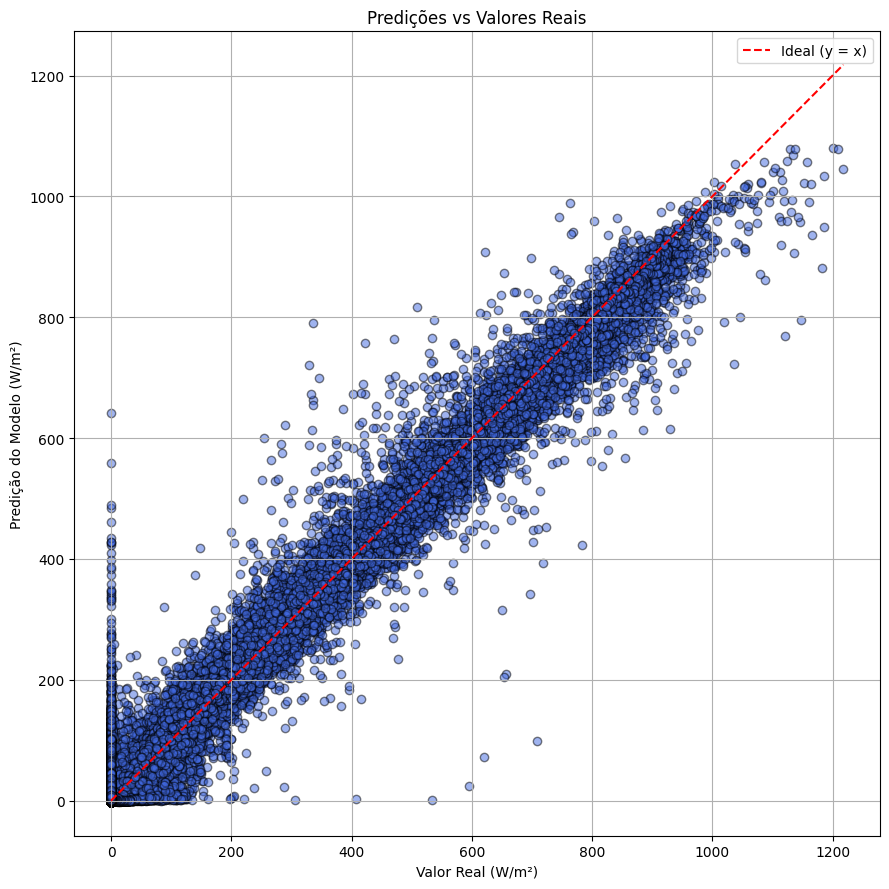

In [32]:
plot_predictions_vs_truth(predictions, ground_truths)
